# <font color='blue'>Mean Machine: Decision Tree Part 1</font>

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to default).

In this notebook, you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be charged off and possibly go into default. The tasks herewith are to

* Use pandas to do some feature engineering.
* Transform categorical variables into binary variables.
* Train a decision-tree on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

# <font color='red'>Import all relevant packages</font>

In [1]:
import numpy as np     # 用来做数学运算
import pandas as pd    # 用来处理数据表

# 将所有图都在 Notebook 里显示
%matplotlib inline               
import matplotlib.pyplot as plt  # 用来画图
from sklearn.model_selection import train_test_split # 做交叉验证，划分训练集和测试集
from sklearn import tree        # 决策树分类器

# <font color='red'>Load Lending Club dataset</font>

In [2]:
loans = pd.read_csv('lending-club-data.csv', low_memory=False)
loans.head(3).append(loans.tail(3))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.143500,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.393200,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.259550,20141201T000000,1,1,1
122604,9695736,11547808,8525,8525,8525,60 months,18.25,217.65,D,D3,...,0.6,0.0,1.0,1.0,0,6.958120,20190101T000000,0,1,0
122605,9684700,11536848,22000,22000,22000,60 months,19.97,582.50,D,D5,...,1.0,1.0,0.0,1.0,0,8.961540,20190101T000000,1,0,1
122606,9604874,11457002,2000,2000,2000,36 months,7.90,62.59,A,A4,...,0.8,0.0,1.0,1.0,0,0.904916,20170101T000000,0,1,1


In [3]:
print( loans.shape )

(122607, 68)


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [4]:
loans.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'is_inc_v', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans',
       'bad_loans', 'emp_length_num', 'grade_num', '

Here, we see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc. Let's take a look at the distribution of loan grades in the dataset.

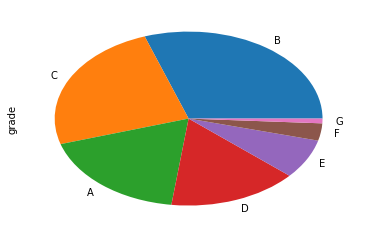

In [5]:
loans['grade'].value_counts().plot(kind='pie')

'We can see that over half of the loan grades are assigned values `B` or `C`. 
Now, let's look at a different feature.

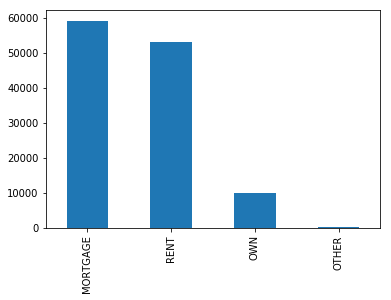

In [6]:
loans['home_ownership'].value_counts().plot(kind='bar')

This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home.

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

We reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [7]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', 1)

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

 Around 81.12% are safe loan and 18.88% are risky loan


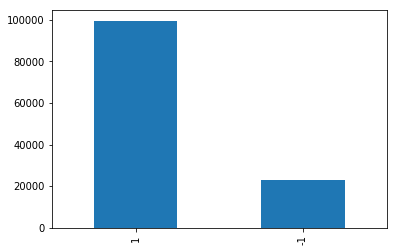

In [8]:
loans['safe_loans'].value_counts().plot(kind='bar')
safe = sum(loans['safe_loans']==1)
risky = sum(loans['safe_loans']==-1)
total = safe+risky
print(' Around %.2f%% are safe loan and %.2f%% are risky loan' \
      %(safe/total*100.0, risky/total*100.0) )

You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

Next we will use a subset of features that are **described in the code comments** below.

In [9]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home_ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'
loans = loans[features + [target]]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

In [10]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
N1 = len(safe_loans_raw)
N2 = len(risky_loans_raw)
N = N1 + N2
print( "# of safe loans  : %s" % N1 )
print( "# of risky loans : %s" % N2 )
print( "%% of safe loans  : %.2f%%" %(N1/N*100.0) )
print( "%% of risky loans : %.2f%%" %(N2/N*100.0) )

# of safe loans  : 99457
# of risky loans : 23150
% of safe loans  : 81.12%
% of risky loans : 18.88%


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `random_state=1` so everyone gets the same results.

In [11]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]

# Since there are fewer risky loans than safe loans, find the ratio of 
# the sizes and use that percentage to undersample the safe loans.
ratio = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=ratio, random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [12]:
N1 = len(safe_loans)
N2 = len(risky_loans)
N = N1 + N2
print( "%% of safe loans  : %.2f%%" %(N1/N*100.0) )
print( "%% of risky loans : %.2f%%" %(N2/N*100.0) )
print( "Total number of loans in our new dataset :", N )

% of safe loans  : 50.00%
% of risky loans : 50.00%
Total number of loans in our new dataset : 46300


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## One-hot Encoding

For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding. 

In [13]:
loans_data.head(3).append(loans_data.tail(3))

,grade,term,home_ownership,emp_length,safe_loans
1,C,60 months,RENT,< 1 year,-1
6,F,60 months,OWN,4 years,-1
7,B,60 months,RENT,< 1 year,-1
90431,B,36 months,RENT,8 years,1
115727,F,60 months,RENT,3 years,1
105752,D,60 months,MORTGAGE,1 year,1


In [14]:
categorical_variables = []
for feat_name, feat_type in zip(loans_data.columns.values,loans_data.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)

categorical_variables

['grade', 'term', 'home_ownership', 'emp_length']

In [15]:
for feature in categorical_variables:
    feat_value = loans_data[feature].unique()
    loans_data_one_hot_encoded = pd.DataFrame()
    for val in feat_value:
        label = feature + '.' + val
        loans_data_one_hot_encoded[label] = loans_data[feature].apply(lambda x: 1 if x == val else 0)
    loans_data = pd.concat([loans_data, loans_data_one_hot_encoded], axis=1)
loans_data = loans_data.drop(categorical_variables,axis=1)

loans_data.head(3).append(loans_data.tail(3))

,safe_loans,grade.C,grade.F,grade.B,grade.D,grade.A,grade.E,grade.G,term. 60 months,term. 36 months,...,emp_length.3 years,emp_length.10+ years,emp_length.1 year,emp_length.9 years,emp_length.2 years,emp_length.8 years,emp_length.7 years,emp_length.5 years,emp_length.n/a,emp_length.6 years
1,-1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,-1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,-1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
90431,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
115727,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
105752,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [16]:
features = loans_data.columns.values
features = features[features != target]
features

array(['grade.C', 'grade.F', 'grade.B', 'grade.D', 'grade.A', 'grade.E',
       'grade.G', 'term. 60 months', 'term. 36 months',
       'home_ownership.RENT', 'home_ownership.OWN',
       'home_ownership.MORTGAGE', 'home_ownership.OTHER',
       'emp_length.< 1 year', 'emp_length.4 years', 'emp_length.3 years',
       'emp_length.10+ years', 'emp_length.1 year', 'emp_length.9 years',
       'emp_length.2 years', 'emp_length.8 years', 'emp_length.7 years',
       'emp_length.5 years', 'emp_length.n/a', 'emp_length.6 years'],
      dtype=object)

## Split data into training and validation sets

We split the data into training and validation sets using an 80/20 split and specifying `random_state=0` so everyone gets the same results. Call the training and validation sets train_data and validation_data, respectively.

Note: In previous notebook, we have called this a train-test split. However, the portion of data that we don't train on will be used to help select model parameters (this is known as model selection). Thus, this portion of data should be called a validation set. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this notebook, we won't do that.

In [17]:
(train_data, validation_data) = train_test_split( loans_data, 
                             train_size=0.8, random_state=0 )
print( train_data.shape, validation_data.shape )
X = train_data[features]
Y = train_data[target]

(37040, 26) (9260, 26)


C:\Users\lilanqing\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# <font color='red'>Use decision tree to build a classifier</font>

Use the built-in scikit learn decision tree learner (`sklearn.tree.DecisionTreeClassifier`) to create a loan prediction model on the training data. Build a `decision_tree_model` with **max depth of 6** and a `small_tree_model` with ** max depth of 2**.

In [18]:
decision_tree_model = tree.DecisionTreeClassifier(max_depth=6)
decision_tree_model = decision_tree_model.fit(X, Y)
print(decision_tree_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [19]:
small_tree_model = tree.DecisionTreeClassifier(max_depth=2)
small_tree_model = small_tree_model.fit(X, Y)
print(small_tree_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [20]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,grade.C,grade.F,grade.B,grade.D,grade.A,grade.E,grade.G,term. 60 months,term. 36 months,...,emp_length.3 years,emp_length.10+ years,emp_length.1 year,emp_length.9 years,emp_length.2 years,emp_length.8 years,emp_length.7 years,emp_length.5 years,emp_length.n/a,emp_length.6 years
113161,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
106326,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
16626,-1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
62925,-1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


## Explore label predictions and probability predictions

Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the `decision_tree_model` and `small_tree_model` to predict whether or not the loan is classified as a **safe loan**. 

Moreover, for each row in the **sample_validation_data**, what is the probability of a loan being classified as **safe**? 

**Hint:** Use the `predict()` and `predict_proba()` method

In [21]:
Ns = sample_validation_data.shape[0]
Xs = sample_validation_data[features]
Ys = sample_validation_data[target]

In [22]:
prediction1 = decision_tree_model.predict(Xs)
prediction2 = decision_tree_model.predict_proba(Xs)

v1 = (prediction1 == Ys.values)
print( prediction1 )
print( Ys.values )
print( v1 )

print( prediction2[:,1] )

[ 1  1 -1 -1]
[ 1  1 -1 -1]
[ True  True  True  True]
[0.55984005 0.80581818 0.30080214 0.45185651]


In [23]:
prediction3 = small_tree_model.predict(Xs)
prediction4 = small_tree_model.predict_proba(Xs)

v3 = (prediction3 == Ys.values)
print( prediction3 )
print( Ys.values )
print( v3 )

print( prediction4[:,1] )

[ 1  1 -1 -1]
[ 1  1 -1 -1]
[ True  True  True  True]
[0.57686244 0.76245211 0.40160346 0.40160346]


# <font color='red'>Evaluating accuracy of the decision tree model</font>

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_tree_model` and `decision_tree_model` on the training data

**Hint:** Use the `score()` method

In [24]:
print( small_tree_model.score(X,Y) )
print( decision_tree_model.score(X,Y) )

0.6144438444924406
0.6217872570194385


You should see that the `small_tree_model` performs worse than the `decision_tree_model` on the training data.

Now, let us evaluate the accuracy of the `small_tree_model` and `decision_tree_model` on the entire **validation_data**, not just the subsample considered above.

In [25]:
Xv = validation_data[features]
Yv = validation_data[target]
print( small_tree_model.score(Xv,Yv) )
print( decision_tree_model.score(Xv,Yv) )

0.6042116630669546
0.6126349892008639


## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model.

In [26]:
big_tree_model = tree.DecisionTreeClassifier(max_depth=10)
big_tree_model = big_tree_model.fit(X, Y)
print(big_tree_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Now, let us evaluate `big_tree_model` on the training set and validation set.

In [27]:
print( big_tree_model.score(X,Y) )
print( big_tree_model.score(Xv,Yv) )

0.6245680345572354
0.6078833693304536
